<a href="https://colab.research.google.com/github/gabrielfernandorey/IEBS/blob/main/01_IEBS_Global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEBS
### Proyecto fin de Postgrado
--- 
- Preparacion de los datos y entrenamiento
- Alumno: Gabriel Rey

## Clonar repositorio

In [ ]:
user='gabrielfernandorey'
git_repository = "https://github.com/"+user+"/IEBS.git"

!git clone {git_repository}

Cloning into 'IEBS'...
remote: Enumerating objects: 12142, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 12142 (delta 61), reused 112 (delta 49), pack-reused 12016
Receiving objects: 100% (12142/12142), 164.33 MiB | 10.19 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Updating files: 100% (12024/12024), done.


## Importamos librerias

In [3]:
import os
import struct
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import librosa
import librosa.display
from IPython import display as ipd
from PIL import Image

In [4]:
# Setear semilla para reproduccion
seed = 42
np.random.seed(seed)

# Suprimir todos los mensajes de advertencia
warnings.filterwarnings("ignore")

## Importar archivos WAV

In [5]:
filenames = !ls -1 '/content/IEBS/Data'
filenames

['BENTEVEO_COMÚN.wav',
 'CABECITANEGRA_COMÚN.wav',
 'CALANDRIA_GRANDE.wav',
 'CARDENAL_AMARILLO.wav',
 'CARDENAL_COMUN.wav',
 'COTORRA.wav',
 'GOLONDRINA_DOMÉSTICA.wav',
 'GORRIÓN.wav',
 'HORNERO.wav',
 'JILGUERO_DORADO.wav',
 'RUIDO.wav',
 'ZORZAL_COLORADO.wav']

In [6]:
num_samples = len(filenames)
print('Numero total de clases:', num_samples)

Numero total de clases: 12


### Atributos de los archivos de audio

In [7]:
class WavFileHelper():
    
    def read_file_properties(self, filename):
        wave_file = open(filename, "rb")

        riff = wave_file.read(12)
        fmt = wave_file.read(36)

        ChunkSizeString = riff[4:8]
        ChunkSize = struct.unpack('I', ChunkSizeString) 
        size = round(ChunkSize[0]/1024)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I", sample_rate_string)[0]
        
        byte_rate_string = fmt[16:20]
        byte_rate = struct.unpack("<I", byte_rate_string)[0] 

        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H", bit_depth_string)[0]
        
        timeInSec = size*1024/byte_rate
        
        return (filename, size, num_channels, sample_rate, round(timeInSec,2), bit_depth)

In [8]:
wavfilehelper = WavFileHelper()

In [9]:
audiodata = []
for file in filenames:
    data = wavfilehelper.read_file_properties('/content/IEBS/Data/'+file)
    audiodata.append(data)

In [10]:
# Visualizamos en un Pandas dataframe los atributos de los archivos de audio
audiodf = pd.DataFrame(audiodata, columns=['filename','KB','num_channels','sample_rate','timeInSec','bit_depth'])
audiodf

filename     KB  num_channels  \
0         /content/IEBS/Data/BENTEVEO_COMÚN.wav   7299             1   
1    /content/IEBS/Data/CABECITANEGRA_COMÚN.wav   8764             1   
2       /content/IEBS/Data/CALANDRIA_GRANDE.wav  10634             1   
3      /content/IEBS/Data/CARDENAL_AMARILLO.wav   5432             1   
4         /content/IEBS/Data/CARDENAL_COMUN.wav   5451             1   
5                /content/IEBS/Data/COTORRA.wav   9900             1   
6   /content/IEBS/Data/GOLONDRINA_DOMÉSTICA.wav   2151             1   
7                /content/IEBS/Data/GORRIÓN.wav   3710             1   
8                /content/IEBS/Data/HORNERO.wav   2846             1   
9        /content/IEBS/Data/JILGUERO_DORADO.wav   3605             1   
10                 /content/IEBS/Data/RUIDO.wav  12928             1   
11       /content/IEBS/Data/ZORZAL_COLORADO.wav  13079             1   

    sample_rate  timeInSec  bit_depth  
0         44100      84.74         16  
1         44100     101.75         16  
2         44100     123.46         16  
3         44100      63.07         16  
4         44100      63.29         16  
5         44100     114.94         16  
6         44100      24.97         16  
7         44100      43.07         16  
8         44100      33.04         16  
9         44100      41.85         16  
10        44100     150.09         16  
11        44100     151.85         16

### Cargar un audio de ejemplo

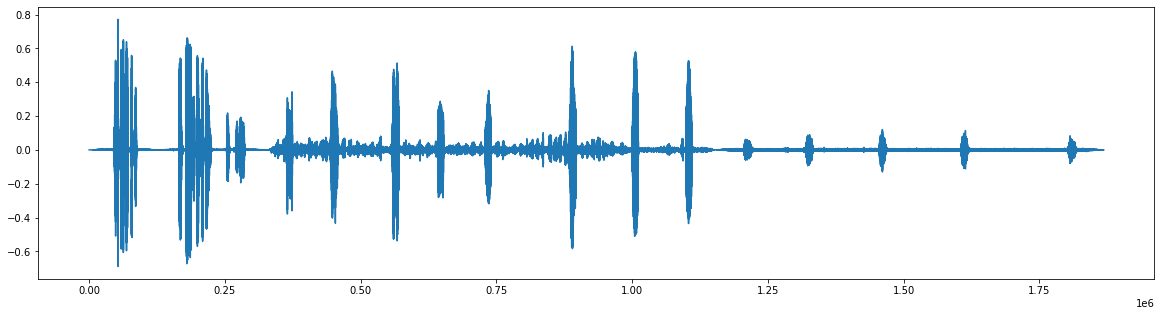

In [11]:
# Cargamos el primer audio de la lista
audio, sr = librosa.load('/content/IEBS/Data/'+filenames[0])
plt.figure(figsize=(20,5))
plt.plot(audio)
ipd.Audio(audio, rate=sr)

### Preprocesamiento


Se define una función para la extracción de N muestras de 5 segundos de duración para cada archivo de audio convertida cada una en espectrograma

In [12]:
class coefs:
       
    # Global vars
    sr = 44100               # librosa sample rate input
    sec = 5                  # seconds   
    sshape = (128, 128)       # height x width
    fmin = 500               # spectrum min frequency
    fmax = 12500             # spectrum max frequency

In [13]:
def extraer_muestras(filename, n_muestras):
    """
    ARGS
      filename: archivo de audio a procesar
      n_muestras: cantidad de muestras a obtener
    """
    carpeta = filename[:-4]
    path_save = '/content/IEBS/Audioimagen/' + carpeta
    os.makedirs(path_save, exist_ok=True)
        
    audio, _ = librosa.load('/content/IEBS/Data/'+filename)

    for n in range(n_muestras):
        start = np.random.randint(1, len(audio)-(coefs.sec * coefs.sr))
        chunk = audio[start:start + coefs.sec * coefs.sr]

        # Espectrograma para cada segmento de audio -------------------------
        hop_length = int(coefs.sec * coefs.sr / (coefs.sshape[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y = chunk, 
                                                  sr = coefs.sr, 
                                                  n_fft = 1024, 
                                                  hop_length = hop_length, 
                                                  n_mels = coefs.sshape[0], 
                                                  fmin = coefs.fmin, 
                                                  fmax = coefs.fmax)
        
        mel_spec = librosa.power_to_db(mel_spec**2, ref=np.max) 

        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Grabar imagen ------------------------------------------------------
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(path_save+'/'+f'{carpeta}_{n}.png')

    print(f" {carpeta} - {n_muestras} Imágenes generadas")
    
    return 

Obtener muestras (espectrogramas) puede demorar 2 minutos.

In [14]:
for i in range(len(filenames)):
  extraer_muestras(filenames[i], 1000)

 BENTEVEO_COMÚN - 1000 Imágenes generadas
 CABECITANEGRA_COMÚN - 1000 Imágenes generadas
 CALANDRIA_GRANDE - 1000 Imágenes generadas
 CARDENAL_AMARILLO - 1000 Imágenes generadas
 CARDENAL_COMUN - 1000 Imágenes generadas
 COTORRA - 1000 Imágenes generadas
 GOLONDRINA_DOMÉSTICA - 1000 Imágenes generadas
 GORRIÓN - 1000 Imágenes generadas
 HORNERO - 1000 Imágenes generadas
 JILGUERO_DORADO - 1000 Imágenes generadas
 RUIDO - 1000 Imágenes generadas
 ZORZAL_COLORADO - 1000 Imágenes generadas


## Modelo Convolucional

In [15]:
import wave
import pylab
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.layers import Input, Dropout
from keras.layers.core import Dense, Flatten, Activation

### Preparar datos de entrenamiento

In [16]:
batch_size = 16
img_height = 128
img_width = 128

DATASET_PATH='/content/IEBS/Audioimagen/'

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
                directory=DATASET_PATH,
                label_mode='categorical',
                validation_split=0.2,
                subset="training",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 12000 files belonging to 12 classes.
Using 9600 files for training.


In [18]:
val_ds = tf.keras.utils.image_dataset_from_directory(
                directory=DATASET_PATH,
                label_mode='categorical',
                validation_split=0.2,
                subset="validation",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 12000 files belonging to 12 classes.
Using 2400 files for validation.


### Obtener nombre de las clases

In [19]:
class_names = train_ds.class_names
print(class_names)

['BENTEVEO_COMÚN', 'CABECITANEGRA_COMÚN', 'CALANDRIA_GRANDE', 'CARDENAL_AMARILLO', 'CARDENAL_COMUN', 'COTORRA', 'GOLONDRINA_DOMÉSTICA', 'GORRIÓN', 'HORNERO', 'JILGUERO_DORADO', 'RUIDO', 'ZORZAL_COLORADO']


### Visualizar un ejemplo

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(12,), dtype=float32)
CABECITANEGRA_COMÚN


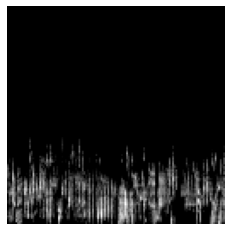

In [20]:
for images, labels in train_ds.take(1):    # cada take contiene la cantidad de imagenes definida en el batch_size
  plt.axis('off')
  plt.imshow(images[0].numpy().astype("uint8")) # visualizamos la primer imagen del batch_size
  print(labels[0])
  print(class_names[np.argmax(labels[0])])

### Modelo CNN + FC
Se modela la red con 4 capas convolucionales y 2 capas densas

In [21]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5), 

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5), 

  layers.Dense(num_classes, activation='softmax')
])

In [22]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.01),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0

### Entrenamiento

In [24]:
epochs=5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
600/600 [==============================] - 23s 15ms/step - loss: 0.5099 - accuracy: 0.8647 - val_loss: 0.1020 - val_accuracy: 0.9996
Epoch 2/5
600/600 [==============================] - 10s 17ms/step - loss: 0.1332 - accuracy: 0.9970 - val_loss: 0.1013 - val_accuracy: 0.9996
Epoch 3/5
600/600 [==============================] - 11s 19ms/step - loss: 0.1168 - accuracy: 0.9995 - val_loss: 0.0869 - val_accuracy: 0.9996
Epoch 4/5
600/600 [==============================] - 8s 14ms/step - loss: 0.1076 - accuracy: 0.9995 - val_loss: 0.0916 - val_accuracy: 1.0000
Epoch 5/5
600/600 [==============================] - 9s 14ms/step - loss: 0.1059 - accuracy: 0.9996 - val_loss: 0.0827 - val_accuracy: 1.0000


In [25]:
# Guardamos el modelo 
model.save('/content/IEBS/Modelos/modelo.h5')

### Visualización de rendimiento

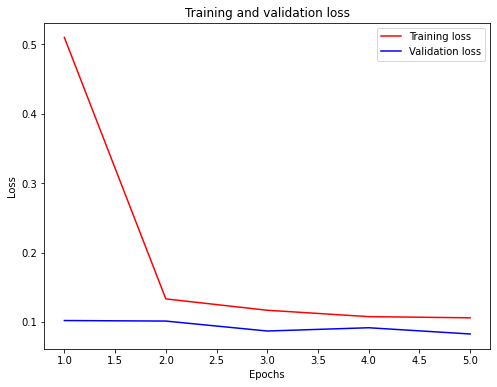

In [26]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

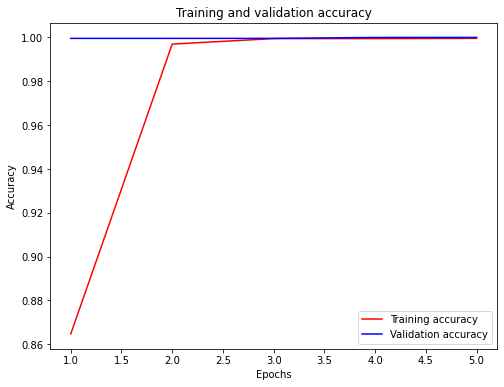

In [27]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Resumen de los valores de loss y accuracy
final_loss, final_acc = model.evaluate(val_ds, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.082659, final accuracy: 1.000000


### Probamos con una imagen conocida aleatoria

In [29]:
from keras.models import load_model

In [30]:
model = load_model('/content/IEBS/Modelos/modelo.h5')

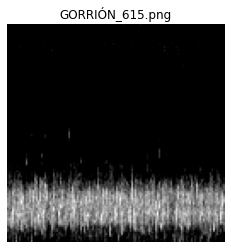

In [31]:
# Ruta del directorio padre
directorio_padre = '/content/IEBS/Audioimagen/'

# Lista de los subdirectorios
subdirectorios = os.listdir(directorio_padre)

# Elige un subdirectorio al azar
subdirectorio_aleatorio = np.random.choice(subdirectorios)

nro = np.random.randint(0, 1000)
imagen = '/content/IEBS/Audioimagen/' + subdirectorio_aleatorio + '/' + subdirectorio_aleatorio + '_' + str(nro) + '.png'
imagen_rgb = mpimg.imread(imagen) # para visualizar la imagen
plt.axis('off')
plt.title(subdirectorio_aleatorio + '_' + str(nro) + '.png')
plt.imshow(imagen_rgb, cmap='gray');

In [32]:
# Clasificacion
imagenMod = tf.keras.preprocessing.image.load_img(imagen, target_size=(128,128))
imagenMod = tf.keras.preprocessing.image.img_to_array(imagenMod)
imagenMod = np.expand_dims(imagenMod, axis=0) #(alto, ancho, 3) -> (1, alto, ancho, 3) 

np.set_printoptions(precision=4, suppress=True)
pred = model.predict(imagenMod).astype("float32")
print(pred)
print()
print(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 226ms/step
[[0.0009 0.0005 0.0003 0.0006 0.0008 0.0007 0.0008 0.9924 0.0012 0.0005
  0.0008 0.0006]]

GORRIÓN


### Aplicacion
Vamos a necesitar instalar la libreria pytube para poder probar audios de videos de youtube no vistos por el modelo

In [33]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 KB 2.9 MB/s eta 0:00:00


In [34]:
from pytube import YouTube

In [35]:
def ordenados(acum_pred, acum_indx):
  """
  funcion que devuelve una lista de tuplas ordenadas
  """
  unicos = np.unique(acum_indx)
  rank = []
  acum=0
  cont=0
  for c in unicos:
    for i in range(len(acum_indx)):
      if c == acum_indx[i]:
        acum += acum_pred[i]  
        cont +=1
    rank.append([c, acum/cont])
    acum=0
    cont=0

  return sorted(rank, key=lambda x: x[1], reverse=True)

In [37]:
def predicciones(url, muestras=15, umbral=0.9):
  """
  funcion que devuelve la prediccion de la clase de un pájaro detectando su canto
  ARGS:
    url: url de un video de youtube que contenga el audio de un pájaro
    muestras: define cuantas muestras del audio (espectrogramas) se evalúan para la prediccion 
    umbral: define que tan segura sea la predicción
  """
  # Descargar el audio del video de YouTube
  youtube_url = url
  yt = YouTube(youtube_url)
  yt.streams.filter(only_audio=True)
  yt.streams.first().download('/content/IEBS/Data/', filename='AUDIO_TEST.wav')

  extraer_muestras('AUDIO_TEST.wav', muestras )

  acum_pred = [] 
  acum_indx = [] 

  for i in range(muestras):
    imagen = '/content/IEBS/Audioimagen/AUDIO_TEST/AUDIO_TEST_'+str(i)+'.png'
    imagen_rgb = mpimg.imread(imagen) # para visualizar la imagen

    # Clasificacion
    imagenMod = tf.keras.preprocessing.image.load_img(imagen, target_size=(128,128))
    imagenMod = tf.keras.preprocessing.image.img_to_array(imagenMod)
    imagenMod = np.expand_dims(imagenMod, axis=0) #(alto, ancho, 3) -> (1, alto, ancho, 3) 

    np.set_printoptions(precision=4, suppress=True)
    
    # Prediccion
    pred = model.predict(imagenMod).astype("float32")

    # Acumular indices
    acum_indx.append(np.argmax(pred))

    # Acumular predicciones
    acum_pred.append(pred[0][np.argmax(pred)])
            
    # Procesar predicciones y presentar
    candidatos, votos = np.unique(acum_indx, return_counts=True)

    # Ordenamos candidatos en funcion de los votos
    lista_combinada = list(zip(candidatos, votos))
    lista_ordenada = sorted(lista_combinada, key=lambda x: x[1], reverse=True)
    candidatos, votos = zip(*lista_ordenada)

  print("###################################")
  if len(acum_indx) > len(candidatos) or len(candidatos)==1:

      prob = c = 0
      for i in range(len(acum_indx)):
          if acum_indx[i] == candidatos[np.argmax(votos)]:
              prob += acum_pred[i]
              c = c+1
      prob /= c
      if prob >= umbral:
          print(f"Umbral: {umbral}")
          print(class_names[candidatos[np.argmax(votos)]], end="")
          print(f"  Probabilidad: {round(prob,4)}")
      else:
          print(f"No se puede predecir con umbral >= {umbral}")
          # Calculo por votacion
          print(acum_indx)
          
          orden_votacion = ordenados(acum_pred, acum_indx)
          if votos[0] == votos[1]: # Hay empate(s), define prob.
            print(f"Votacion por mayoria (mas similar a): {class_names[orden_votacion[0][0]]}")
          else:
            print(f"Votacion ponderada por probabilidad (mas similar a): {class_names[candidatos[np.argmax(votos)]]}")
          print("-----------------------------------")
          
  else:
      print("No se puede predecir")
  
  print("###################################")
  print()

  return [acum_pred, acum_indx]

Las url's a continuación fueron extraidas de videos con audio de los pájaros de las clases entrenadas. 

- El valor de las muestras es recomendable que sea no menor a 10

In [38]:
url = 'https://www.youtube.com/watch?v=D_OvrN0ekao&t=228s' # Zorzal colorado
#url = 'https://www.youtube.com/watch?v=bRPgMuPJeY4&t=331s'  # Benteveo
#url = 'https://www.youtube.com/watch?v=R2rW363ydE8&t=29s' # Cabecita negra
#url = 'https://www.youtube.com/watch?v=GRNA_GFeZIs' # Calandria Grande
#url = 'https://www.youtube.com/watch?v=f0S6ANb7W1Q&t=1325s' # Cardenal amarillo
#url = 'https://www.youtube.com/watch?v=cO0bsV8vePg' # Cardenal comun
#url = 'https://www.youtube.com/watch?v=oibxurOe1zE' # Cotorra
#url = 'https://www.youtube.com/watch?v=zsvapbpmwNY&t=110s' #Golondrina domestica x
#url = 'https://www.youtube.com/watch?v=TPuG-FOa1yw&t=971s' # Gorrion x
#url = 'https://www.youtube.com/watch?v=6hZtOsnc7SE' # Hornero x
#url = 'https://www.youtube.com/watch?v=kviBd6K-eF4&t=438s' # Jilguero dorado

acum_pred, acum_indx = predicciones(url, muestras=15, umbral=0.8 )

 AUDIO_TEST - 15 Imágenes generadas
1/1 [==============================] - 0s 21ms/step
###################################
Umbral: 0.8
ZORZAL_COLORADO  Probabilidad: 0.957
###################################

